<a href="https://colab.research.google.com/github/Shubangi-Saxena/Intent_Recognition_Shreya_Shubangi_Srushti/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

In [ ]:
TRAIN_PATH = f"train.tsv"
VAL_PATH = f"dev.tsv"
TEST_PATH = f"test.tsv"
df = pd.read_csv(TEST_PATH,sep='\t',names = ["Intent", "sentence","something"])
df_train=pd.DataFrame()
def load_snips_file(file_path):
    list_pair =[]
    with open(file_path,'r',encoding="utf8") as f:
        for line in f:
            split_line = line.split('\t')
            pair = split_line[0],split_line[1]
            list_pair.append(pair)
    return list_pair
all_train_examples = load_snips_file(TRAIN_PATH)
valid_examples = load_snips_file(VAL_PATH)
test_examples = load_snips_file(TEST_PATH)
df.head()

,Intent,sentence,something
0,AddToPlaylist,add sabrina salerno to the grime instrumentals...,O B-artist I-artist O O B-playlist I-playlist O
1,BookRestaurant,i want to bring four people to a place that s ...,O O O O B-party_size_number O O O O O O B-spat...
2,AddToPlaylist,put lindsey cardinale into my hillary clinton ...,O B-artist I-artist O B-playlist_owner B-playl...
3,GetWeather,will it snow in mt on june 13 2038,O O B-condition_description O B-state O B-time...
4,PlayMusic,play signe anderson chant music that is newest,O B-artist I-artist B-music_item O O O B-sort


In [ ]:
df.drop("something", axis='columns')

,Intent,sentence
0,AddToPlaylist,add sabrina salerno to the grime instrumentals...
1,BookRestaurant,i want to bring four people to a place that s ...
2,AddToPlaylist,put lindsey cardinale into my hillary clinton ...
3,GetWeather,will it snow in mt on june 13 2038
4,PlayMusic,play signe anderson chant music that is newest
...,...,...
695,SearchCreativeWork,find a tv series called armageddon summer
696,SearchCreativeWork,find politicsnation with al sharpton
697,RateBook,rate this album 0 points out of 6
698,AddToPlaylist,add leah kauffman to my uncharted 4 nathan dra...


In [ ]:
#How many training examples are there for each intent?
intent_series = pd.Series(np.array(all_train_examples)[:,0])
intent_series.value_counts()

PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
dtype: int64

In [ ]:
def load_dataset(filename):
  df_train = pd.read_csv(TRAIN_PATH,sep='\t',names = ["Intent", "sentences","something"])
  df_train.drop("something", axis='columns')
  intent = df_train["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df_train["sentences"])
  
  return (intent, unique_intent, sentences)


In [ ]:
intent, unique_intent, sentences = load_dataset("train.csv")

In [ ]:
print(sentences[:10])

['listen to westbam alumb allergic on google music', 'add step to me to the 50 clásicos playlist', 'i give this current textbook a rating value of 1 and a best rating of 6', 'play the song little robin redbreast', 'please add iris dement to my playlist this is selena', 'add slimm cutta calhoun to my this is prince playlist', 'i want to listen to seventies music', 'play a popular chant by brian epstein', 'find fish story', 'book a spot for 3 in mt']


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#define stemmer
stemmer = LancasterStemmer()

In [ ]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words  

In [ ]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2]) 

13084
[['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music'], ['add', 'step', 'to', 'me', 'to', 'the', '50', 'cl', 'sicos', 'playlist']]


Keras tokenizer

In [ ]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [ ]:
def max_lengthh(words):
  return(len(max(words, key = len)))

In [ ]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_lengthh(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 11059 and Maximum length = 35


One hot encoding for the model

In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [ ]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
padded_doc[:5]

array([[ 188,    4, 4425, 4426, 4427,   18,  203,   35,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  12,  431,    4,   17,    4,    1,  318, 1002, 1115,   16,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   7,   29,   19,   37,  100,    2,   73,  251,    6,   53,   24,
           2,  111,   73,    6,   20,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   9,    1,   47,  358,  756, 4428,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  57,   12, 2130, 28

In [ ]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [ ]:
output_tokenizer.word_index

{'getweather': 1,
 'bookrestaurant': 2,
 'searchscreeningevent': 3,
 'searchcreativework': 4,
 'ratebook': 5,
 'addtoplaylist': 6,
 'playmusic': 7}

In [ ]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [ ]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)

In [ ]:
print(output_one_hot)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (10467, 35) and train_Y = (10467, 7)
Shape of val_X = (2617, 35) and val_Y = (2617, 7)


In [ ]:
print(train_Y)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Model

In [ ]:
'''def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(21, activation = "softmax"))
  
  return model'''

'def create_model(vocab_size, max_length):\n  model = Sequential()\n  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))\n  model.add(Bidirectional(LSTM(128)))\n#   model.add(LSTM(128))\n  model.add(Dense(32, activation = "relu"))\n  model.add(Dropout(0.5))\n  model.add(Dense(21, activation = "softmax"))\n  \n  return model'

In [65]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size,128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Bidirectional(LSTM(64)))
  #model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))
  return model

In [66]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [67]:
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy",f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 128)           1415552   
                                                                 
 bidirectional_2 (Bidirectio  (None, 35, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 7)                

In [68]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#print(train_X.shape)
#print(train_Y.shape)
#print(val_X.shape)
#print(val_Y.shape)
hist = model.fit(x=train_X, y=train_Y, epochs = 5, batch_size = 16, validation_data = (val_X, val_Y))

Epoch 1/5
655/655 [==============================] - 95s 130ms/step - loss: 1.0095 - accuracy: 0.6066 - f1_m: 0.5428 - precision_m: 0.7607 - recall_m: 0.4441 - val_loss: 0.3766 - val_accuracy: 0.8968 - val_f1_m: 0.8939 - val_precision_m: 0.9269 - val_recall_m: 0.8650
Epoch 2/5
655/655 [==============================] - 83s 126ms/step - loss: 0.4379 - accuracy: 0.8712 - f1_m: 0.8602 - precision_m: 0.9137 - recall_m: 0.8169 - val_loss: 0.2223 - val_accuracy: 0.9312 - val_f1_m: 0.9326 - val_precision_m: 0.9452 - val_recall_m: 0.9212
Epoch 3/5
655/655 [==============================] - 82s 125ms/step - loss: 0.2979 - accuracy: 0.9180 - f1_m: 0.9147 - precision_m: 0.9426 - recall_m: 0.8900 - val_loss: 0.1696 - val_accuracy: 0.9465 - val_f1_m: 0.9465 - val_precision_m: 0.9579 - val_recall_m: 0.9361
Epoch 4/5
655/655 [==============================] - 85s 130ms/step - loss: 0.2364 - accuracy: 0.9368 - f1_m: 0.9351 - precision_m: 0.9537 - recall_m: 0.9185 - val_loss: 0.1710 - val_accuracy: 0.9

In [69]:
loss = pd.DataFrame({'loss': model.history.history['accuracy'], 'auc': model.history.history['val_accuracy'] })

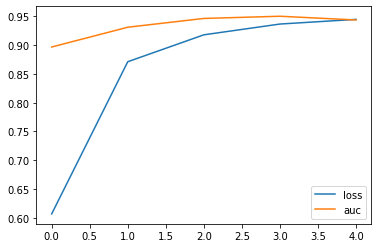

In [70]:
loss.plot()

In [71]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))

  test_ls = np.array(test_ls).reshape(1, len(test_ls))

  x = padding_doc(test_ls, max_length)


  #pred=np.argmax(model.predict(x), axis=-1)
  pred=model.predict(x)
  #print(pred_classes)
  return pred

In [72]:
def get_final_output(pred, classes):
  predictions = pred[0]
  print(pred[0])
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions =-np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))


In [73]:
text = "please search the young warriors game"
pred = predictions(text)
get_final_output(pred, unique_intent)

['please', 'search', 'the', 'young', 'warriors', 'game']
1/1 [==============================] - 2s 2s/step
[1.1507150e-04 2.0209183e-04 3.3381777e-03 9.9466407e-01 9.3445246e-04
 1.4356585e-04 6.0241658e-04]
SearchCreativeWork has confidence = 0.9946641
SearchScreeningEvent has confidence = 0.0033381777
RateBook has confidence = 0.00093445246
PlayMusic has confidence = 0.0006024166
BookRestaurant has confidence = 0.00020209183
AddToPlaylist has confidence = 0.00014356585
GetWeather has confidence = 0.0001150715


Test Data Prep

In [ ]:
intent_test, unique_intent_test, sentences_test = load_dataset("test.csv")

In [ ]:
cleaned_words_test=cleaning(sentences_test)
word_tokenizer_test = create_tokenizer(cleaned_words_test)
vocab_size_test = len(word_tokenizer.word_index) + 1
max_length_test = max_lengthh(cleaned_words_test)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size_test, max_length_test))

Vocab Size = 11059 and Maximum length = 35


In [ ]:
encoded_doc_test = encoding_doc(word_tokenizer_test, cleaned_words_test)

In [ ]:
padded_doc_test = padding_doc(encoded_doc_test, max_length_test)

In [ ]:
#tokenizer with filter changed
output_tokenizer_test = create_tokenizer(unique_intent_test, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [ ]:
encoded_output_test = encoding_doc(output_tokenizer_test, intent_test)

In [ ]:
encoded_output_test = np.array(encoded_output_test).reshape(len(encoded_output_test), 1)

In [ ]:
output_one_hot_test = one_hot(encoded_output_test)

In [ ]:
X_test=padded_doc_test
Y_test=output_one_hot_test


In [74]:
accr_gru = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_gru[0],accr_gru[1]))

409/409 [==============================] - 30s 73ms/step - loss: 0.1622 - accuracy: 0.9507 - f1_m: 0.9520 - precision_m: 0.9597 - recall_m: 0.9447
Test set
  Loss: 0.162
  Accuracy: 0.951
